In [87]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
import pandas as pd

message_gold_label = pd.read_csv('message_gold_label.csv')
potential = pd.read_csv('potential.csv')

campaign = pd.read_csv('campaigns.csv')

# Concatenate the DataFrames
data = pd.concat([message_gold_label, potential], ignore_index=True)
data = data[data['message_type'] == 'bulk']

# Drop the specified columns
columns_to_drop = ['is_unsubscribed', 'unsubscribed_at', 'complained_at','is_complained', 'is_blocked', 
                   'blocked_at', 'purchased_at', 'date', 'campaign_message','opened_first_time_at',
                   'clicked_first_time_at','is_opened','is_clicked','client_id','message_id']
data = data.drop(columns=columns_to_drop)

columns_to_drop_campaign = ['is_test','position','hour_limit','warmup_mode','ab_test','started_at','finished_at','total_count']
campaign = campaign.drop(columns=columns_to_drop_campaign)

data

,campaign_id,message_type,channel,sent_at,opened_last_time_at,clicked_last_time_at,is_purchased,duration
3121,136,bulk,email,2021-05-19 07:50:47,2021-05-20 02:41:19,2021-05-20 02:41:19,True,22.0
3122,136,bulk,email,2021-05-19 07:07:20,2021-05-19 20:05:03,2021-05-19 20:05:03,True,31451.0
3123,136,bulk,email,2021-05-19 07:01:43,2021-05-20 11:45:38,2021-05-20 11:45:38,True,37.0
3124,136,bulk,email,2021-05-19 07:43:20,2021-05-20 11:38:03,2021-05-20 11:38:03,True,12.0
3125,136,bulk,email,2021-05-19 07:22:16,2021-05-19 11:22:25,2021-05-19 11:22:25,True,10780.0
...,...,...,...,...,...,...,...,...
164177,361,bulk,email,2021-06-11 08:10:11,2021-06-11 09:20:29,2021-06-11 09:20:29,False,24.0
164180,361,bulk,email,2021-06-11 08:04:06,2021-06-11 08:22:01,2021-06-11 08:22:01,False,25.0
164181,361,bulk,email,2021-06-11 08:04:07,2021-06-15 23:05:16,2021-06-15 23:05:16,False,9.0
164182,361,bulk,email,2021-06-11 08:08:07,2021-06-11 09:08:23,2021-06-11 09:08:23,False,164.0


In [89]:
merged_data = pd.merge(data, campaign, 
                       left_on=['campaign_id','message_type'], 
                       right_on=['id', 'campaign_type'])
merged_data = merged_data.drop(columns=['id','campaign_type','channel_y','campaign_id','message_type'])

merged_data.head()

,channel_x,sent_at,opened_last_time_at,clicked_last_time_at,is_purchased,duration,topic,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout
0,email,2021-05-19 07:50:47,2021-05-20 02:41:19,2021-05-20 02:41:19,True,22.0,sale out,133.0,False,False,True,False,False,False
1,email,2021-05-19 07:07:20,2021-05-19 20:05:03,2021-05-19 20:05:03,True,31451.0,sale out,133.0,False,False,True,False,False,False
2,email,2021-05-19 07:01:43,2021-05-20 11:45:38,2021-05-20 11:45:38,True,37.0,sale out,133.0,False,False,True,False,False,False
3,email,2021-05-19 07:43:20,2021-05-20 11:38:03,2021-05-20 11:38:03,True,12.0,sale out,133.0,False,False,True,False,False,False
4,email,2021-05-19 07:22:16,2021-05-19 11:22:25,2021-05-19 11:22:25,True,10780.0,sale out,133.0,False,False,True,False,False,False


In [90]:
def extract_datetime_features(X, datetime_columns):
    """
    Extracts weekday, hour, and month from datetime columns in a DataFrame and drops the original columns.

    Parameters:
    - X (pd.DataFrame): The input DataFrame containing datetime columns.
    - datetime_columns (list): A list of column names in X that contain datetime data.

    Returns:
    - pd.DataFrame: The modified DataFrame with extracted datetime features.
    """
    for col in datetime_columns:
        if col in X.columns:
            X[col + '_weekday'] = pd.to_datetime(X[col]).dt.weekday
            X[col + '_hour'] = pd.to_datetime(X[col]).dt.hour
            X[col + '_month'] = pd.to_datetime(X[col]).dt.month
            X = X.drop(columns=[col])  
    return X
merged_data_date_time_feature = extract_datetime_features(merged_data, ['sent_at','opened_last_time_at','clicked_last_time_at'])

In [91]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def drop_and_encode(df, encode_columns):
    """
    Function to drop specified columns and encode categorical columns using LabelEncoder.

    Parameters:
    - df: pandas DataFrame, input data.
    - encode_columns: list of column names to encode using LabelEncoder.

    Returns:
    - df: pandas DataFrame with specified columns dropped and categorical columns encoded.
    """
    le = LabelEncoder()
    
    for col in encode_columns:
        if col in df.columns:
            # Xử lý NaN (thay NaN bằng 'missing' hoặc giá trị thay thế)
            df[col] = df[col].fillna('missing').astype(str)  # Thay NaN bằng 'missing'
            # Encode the column and add it as a new column
            df[col + '_encoded'] = le.fit_transform(df[col])  # Chuyển đổi thành số
            # Drop the original column after encoding
            df = df.drop(columns=[col])
    
    return df


def process_bool_columns(df, bool_columns):
    """
    Convert boolean columns to integer (0, 1).

    Parameters:
    - df: pandas DataFrame, input data.
    - bool_columns: list of column names to convert to integers.

    Returns:
    - df: pandas DataFrame with boolean columns converted to integers.
    """
    for col in bool_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)  # Chuyển đổi boolean thành 0 và 1
    return df


def convert_to_numeric(df, numerical_columns):
    """
    Convert specified columns to numeric, coercing errors to NaN.

    Parameters:
    - df: pandas DataFrame, input data.
    - numerical_columns: list of column names to convert to numeric.

    Returns:
    - df: pandas DataFrame with numeric columns converted.
    """
    for col in numerical_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển thành số và xử lý lỗi
    return df


# Example usage:

# Encode categorical columns
encode_columns = ['topic', 'channel_x']
merged_data_date_time_feature = drop_and_encode(merged_data_date_time_feature, encode_columns)

# Process boolean columns
bool_columns = [ 'subject_with_personalization', 'subject_with_deadline',
                 'subject_with_emoji', 'subject_with_bonuses', 
                 'subject_with_discount', 'subject_with_saleout', 'is_purchased']
merged_data_date_time_feature = process_bool_columns(merged_data_date_time_feature, bool_columns)

# Convert specified numerical columns to numeric type
numerical_columns = ['channel_x', 'duration', 'topic', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'sent_at_weekday', 'sent_at_hour',
       'sent_at_month', 'opened_last_time_at_weekday',
       'opened_last_time_at_hour', 'opened_last_time_at_month',
       'clicked_last_time_at_weekday', 'clicked_last_time_at_hour',
       'clicked_last_time_at_month']
merged_data_date_time_feature = convert_to_numeric(merged_data_date_time_feature, numerical_columns)

# Display the DataFrame to check the result
merged_data_date_time_feature

,is_purchased,duration,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,sent_at_weekday,sent_at_hour,sent_at_month,opened_last_time_at_weekday,opened_last_time_at_hour,opened_last_time_at_month,clicked_last_time_at_weekday,clicked_last_time_at_hour,clicked_last_time_at_month,topic_encoded,channel_x_encoded
0,1,22.0,133.0,0,0,1,0,0,0,2,7,5,3,2,5,3,2,5,2,0
1,1,31451.0,133.0,0,0,1,0,0,0,2,7,5,2,20,5,2,20,5,2,0
2,1,37.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
3,1,12.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
4,1,10780.0,133.0,0,0,1,0,0,0,2,7,5,2,11,5,2,11,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71145,0,0.0,117.0,0,0,1,0,0,0,4,10,6,4,10,6,4,10,6,2,1
71146,0,0.0,117.0,0,0,1,0,0,0,4,10,6,4,10,6,4,10,6,2,1
71147,0,0.0,117.0,0,0,1,0,0,0,4,10,6,0,10,6,0,10,6,2,1
71148,0,0.0,111.0,0,0,1,0,0,0,4,14,6,4,14,6,4,14,6,2,1


In [92]:
cleaned_data = merged_data_date_time_feature.drop_duplicates()
cleaned_data

,is_purchased,duration,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,sent_at_weekday,sent_at_hour,sent_at_month,opened_last_time_at_weekday,opened_last_time_at_hour,opened_last_time_at_month,clicked_last_time_at_weekday,clicked_last_time_at_hour,clicked_last_time_at_month,topic_encoded,channel_x_encoded
0,1,22.0,133.0,0,0,1,0,0,0,2,7,5,3,2,5,3,2,5,2,0
1,1,31451.0,133.0,0,0,1,0,0,0,2,7,5,2,20,5,2,20,5,2,0
2,1,37.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
3,1,12.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
4,1,10780.0,133.0,0,0,1,0,0,0,2,7,5,2,11,5,2,11,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71118,0,0.0,117.0,0,0,1,0,0,0,4,10,6,4,15,6,4,15,6,2,1
71143,0,0.0,117.0,0,0,1,0,0,0,4,10,6,4,18,6,4,18,6,2,1
71147,0,0.0,117.0,0,0,1,0,0,0,4,10,6,0,10,6,0,10,6,2,1
71148,0,0.0,111.0,0,0,1,0,0,0,4,14,6,4,14,6,4,14,6,2,1


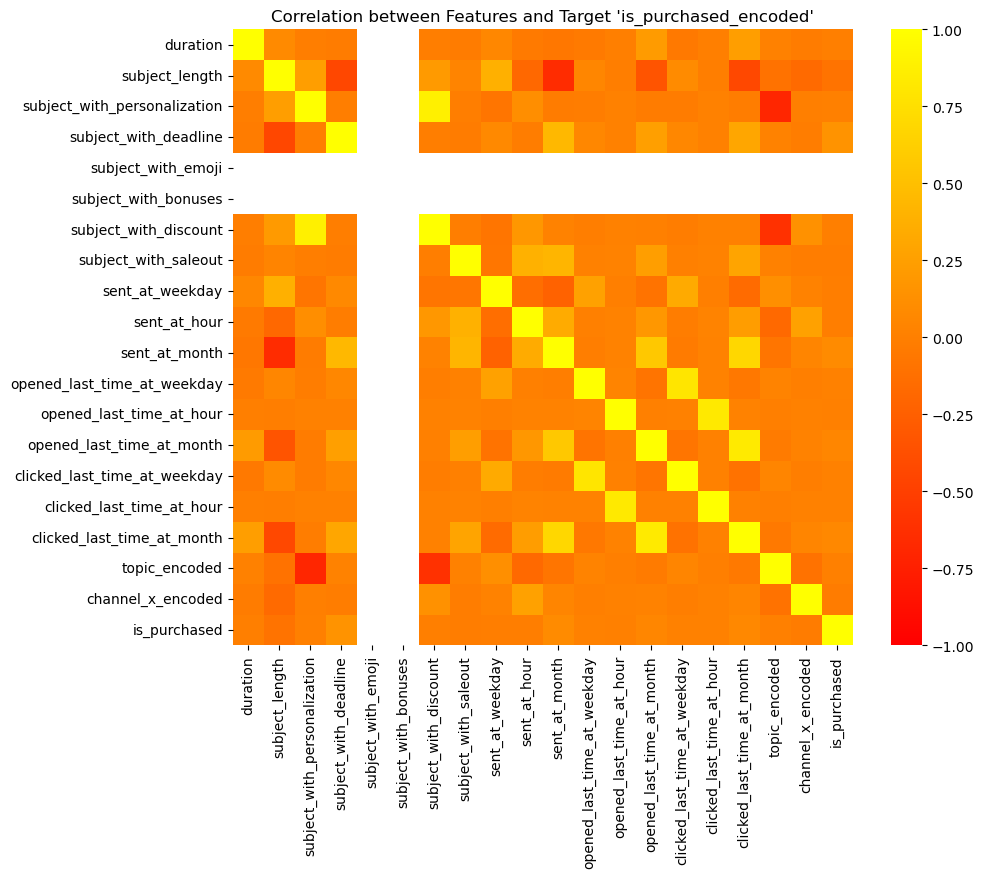

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


numerical_features  =['duration', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'sent_at_weekday', 'sent_at_hour',
       'sent_at_month', 'opened_last_time_at_weekday',
       'opened_last_time_at_hour', 'opened_last_time_at_month',
       'clicked_last_time_at_weekday', 'clicked_last_time_at_hour',
       'clicked_last_time_at_month', 'topic_encoded', 'channel_x_encoded']

correlation_matrix = cleaned_data[numerical_features + ['is_purchased']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1,cmap='autumn')
plt.title("Correlation between Features and Target 'is_purchased_encoded'")
plt.show()


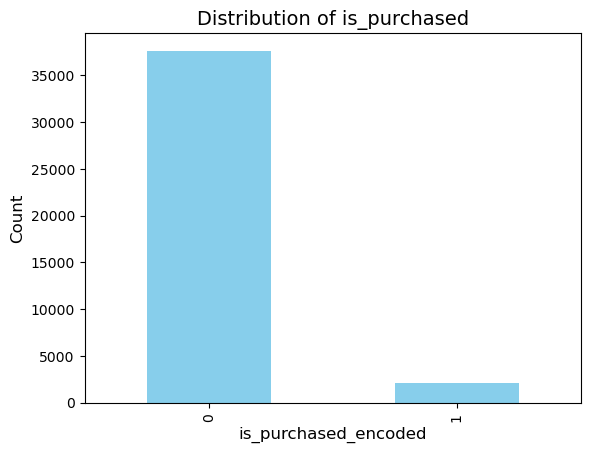

In [94]:
import matplotlib.pyplot as plt

purchase_counts = cleaned_data['is_purchased'].value_counts()

purchase_counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of is_purchased', fontsize=14)
plt.xlabel('is_purchased_encoded', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

### Dữ liệu bị mất cân bằng
- Undersampling giúp giảm kích thước dữ liệu và tiết kiệm tài nguyên tính toán, rất hữu ích khi tài nguyên bị hạn chế.
- Oversampling có thể làm tăng kích thước dữ liệu, điều này gây khó khăn khi tài nguyên tính toán bị giới hạn

In [95]:
X = cleaned_data.drop(columns=['is_purchased'])
y = cleaned_data['is_purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

undersampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)

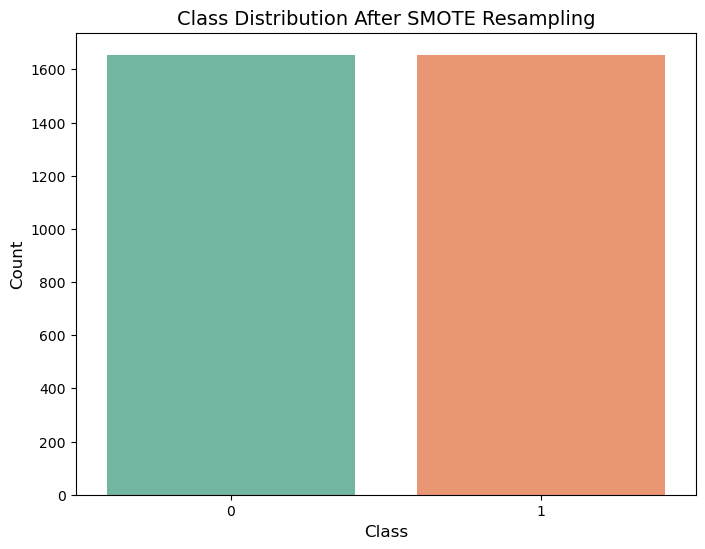

In [96]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res, palette="Set2")
plt.title('Class Distribution After SMOTE Resampling', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# MODEL

In [97]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge, ElasticNet, RidgeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score

def model_feature_selection(X_train, y_train, model):
    """
    Perform feature selection using a linear model.
    
    Parameters:
        X_train (pd.DataFrame): Feature dataset for training.
        y_train (pd.Series or np.array): Target variable for training.
        model: Scikit-learn model with a coef_ or feature_importances_ attribute.

    Returns:
        selected_features (list): List of selected feature names.
        model: Trained model.
    """
    model.fit(X_train, y_train)
    selector = SelectFromModel(model, prefit=True, threshold=1e-5)
    selected_features = X_train.columns[selector.get_support()].tolist()
    return selected_features, model

def grid_search_model(X_train, y_train, model_class, param_grid):
    """
    Perform grid search to find the best hyperparameters for a given model.

    Parameters:
        X_train (pd.DataFrame): Feature dataset for training.
        y_train (pd.Series or np.array): Target variable for training.
        model_class: Model class (e.g., LogisticRegression, Ridge).
        param_grid (dict): Grid of parameters to search.

    Returns:
        best_params (dict): Best hyperparameters found by grid search.
        best_model: Best model trained with optimal hyperparameters.
    """
    model = model_class()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set and return accuracy and MSE.

    Parameters:
        model: Trained model.
        X_test (pd.DataFrame): Test feature dataset.
        y_test (pd.Series or np.array): Test target variable.

    Returns:
        accuracy (float): Accuracy score on the test set.
        mse (float): Mean Squared Error on the test set.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, mse


def print_model_coefficients(model, feature_names):
    """
    In ra hệ số của mô hình cho từng đặc trưng.

    Parameters:
        model: Trained model có thuộc tính coef_.
        feature_names: Danh sách tên các đặc trưng (cột trong dataset).
    """
    coefficients = model.coef_.flatten()  
    coef_dict = dict(zip(feature_names, coefficients))  # Kết hợp tên đặc trưng với hệ số
    sorted_coef = dict(sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True))  # Sắp xếp theo độ lớn
    print("\nModel Coefficients (sorted by importance):")
    for feature, coef in sorted_coef.items():
        print(f"{feature}: {coef:.4f}")

logistic_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Mở rộng phạm vi
    'solver': ['liblinear', 'saga'],  # Thêm solver
    'penalty': ['l1'],  # L1 penalty
    'max_iter': [100, 200, 500, 1000]  # Tăng số vòng lặp
}
logistic_params, logistic_model = grid_search_model(X_train_res, y_train_res, LogisticRegression, logistic_param_grid)
logistic_features, logistic_model = model_feature_selection(X_train_res, y_train_res, logistic_model)
logistic_accuracy, logistic_mse = evaluate_model(logistic_model, X_test, y_test)

# Print the results for Logistic Regression
print("Logistic Regression (L1) Best Params:", logistic_params)
print("Logistic Regression Selected Features:", logistic_features)
print("Logistic Regression Test Accuracy:", logistic_accuracy)
print("Logistic Regression Test MSE:", logistic_mse)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

Logistic Regression (L1) Best Params: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Selected Features: ['subject_length', 'subject_with_personalization', 'subject_with_deadline', 'subject_with_saleout', 'sent_at_weekday', 'sent_at_hour', 'sent_at_month', 'opened_last_time_at_weekday', 'opened_last_time_at_hour', 'opened_last_time_at_month', 'clicked_last_time_at_weekday', 'clicked_last_time_at_hour', 'clicked_last_time_at_month', 'topic_encoded', 'channel_x_encoded']
Logistic Regression Test Accuracy: 0.7624622356495468
Logistic Regression Test MSE: 0.23753776435045318


### Sau khi dùng phương pháp 

**Tổng quan:**
- Độ chính xác 76.24% là một chỉ số khá tốt trong các bài toán phân loại, tuy nhiên vẫn có thể cải thiện nếu mục tiêu là đạt được sự phân biệt rõ ràng giữa các lớp.
- MSE 0.2411 cho thấy mô hình chưa hoàn hảo và có sai lệch nhất định trong các dự đoán.
Để cải thiện mô hình, có thể cần phải cân nhắc thêm việc điều chỉnh siêu tham số, cải thiện các đặc trưng (features), hoặc thử nghiệm với các mô hình khác.

**Lưu ý:** 
1. Biến động của Accuracy:
Accuracy (độ chính xác) có thể thay đổi từ 75% đến 78% vì:
Quá trình undersampling khiến mô hình học được trên một tập dữ liệu khác nhau mỗi khi chạy.
Mỗi lần undersampling có thể loại bỏ các mẫu khác nhau từ lớp chiếm ưu thế, tạo ra các biến thể trong dữ liệu huấn luyện, từ đó dẫn đến sự thay đổi trong kết quả dự đoán của mô hình.
2. Biến động của MSE:
MSE (Mean Squared Error) có thể thay đổi trong khoảng từ 0.1 đến 0.25 vì:
MSE tính toán mức độ sai lệch giữa giá trị dự đoán và giá trị thực tế. Với việc sử dụng undersampling, tập dữ liệu huấn luyện có thể thay đổi, khiến mô hình có thể học được các đặc trưng khác nhau, dẫn đến sai số dự đoán thay đổi.
